<a href="https://colab.research.google.com/github/mmilannaik/Campus-DL/blob/main/Customer_Churn_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869651%2F1481789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T094417Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64d779162f23d74a117ca15528cc04283ac9d98092f287ea2ea9845ec586832716965a0ff9180e23d2e1e543e5947e7ea175df47f2d4e9deaec252ac96318ed0170ccd3d35bf005b2a1bc8ba3fe1aed250d80296611e9cf14881a04116d06df8a57080eca5f7be3a3028d31815d86492b8d851d22ef845b17e31c856140dc69dfc318e6b46df2224ca703d4c14865b5adc0554510bf00bfff52ecd8edc405a9f851bcd2707ced63b2136b1301f19571f9b0843ea1eee310bd7f85feb386c4742af38953b2bdaaa5c642c98e1696494a0da9fd60b930eb1b9971d9e52db3e5f9cbf7913f4986d03b3f15f032a5a2ae6daefa8f8233f85f30f4f631a9d5cbc4c53'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: credit-card-customer-churn-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [3]:
df = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.duplicated().sum()

0

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [8]:
df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [9]:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [10]:
df.drop(columns = ['RowNumber','CustomerId','Surname'],inplace=True)

In [11]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)

In [13]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [14]:
# Replace True with 1 and False with 0
df_replaced = df.replace({True: 1, False: 0})

In [16]:
df_replaced.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [17]:
X = df_replaced.drop(columns=['Exited'])
y = df_replaced['Exited'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

In [21]:
X_train_trf

array([[ 0.16958176, -0.46460796,  0.00666099, ..., -0.5698444 ,
         1.74309049, -1.09168714],
       [-2.30455945,  0.30102557, -1.37744033, ...,  1.75486502,
        -0.57369368,  0.91601335],
       [-1.19119591, -0.94312892, -1.031415  , ..., -0.5698444 ,
        -0.57369368, -1.09168714],
       ...,
       [ 0.9015152 , -0.36890377,  0.00666099, ..., -0.5698444 ,
        -0.57369368,  0.91601335],
       [-0.62420521, -0.08179119,  1.39076231, ..., -0.5698444 ,
         1.74309049, -1.09168714],
       [-0.28401079,  0.87525072, -1.37744033, ...,  1.75486502,
        -0.57369368, -1.09168714]])

In [22]:
X_train_trf.shape

(8000, 11)

In [19]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [27]:
model = Sequential()

model.add(Dense(3,activation='sigmoid',input_dim=11))
model.add(Dense(1,activation='sigmoid'))
#model.add(Dense(1,activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 3)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40 (160.00 B)

 Trainable params: 40 (160.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
model.fit(X_train_trf,y_train,epochs = 10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7918 - loss: 0.5182
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7948 - loss: 0.4848
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7904 - loss: 0.4756
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4444
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7944 - loss: 0.4485
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7978 - loss: 0.4371
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7960 - loss: 0.4409
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8006 - loss: 0.4271
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8001 - loss: 0.4320
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8043 - loss: 0.4260


In [31]:
model.layers[0].get_weights()

[array([[ 0.18103237,  0.07707532,  0.03207343],
        [-1.1916564 , -0.8305764 , -1.5106459 ],
        [-0.1674031 ,  0.3707919 , -0.00489981],
        [ 0.0020006 , -0.4399242 ,  0.00595882],
        [ 0.9127045 , -0.2702429 ,  0.38706276],
        [ 0.17269796, -0.07683276, -0.03280235],
        [ 0.37731117,  0.871706  ,  0.35919097],
        [-0.25831813, -0.01062454,  0.19446391],
        [-0.45641026, -0.6984411 , -0.4495926 ],
        [-0.255458  , -0.03162355,  0.03552077],
        [ 0.44710806,  0.31993514,  0.5827641 ]], dtype=float32),
 array([0.32017353, 0.12391697, 0.16533011], dtype=float32)]

In [32]:
model.layers[1].get_weights()

[array([[-1.0794917 ],
        [-1.430803  ],
        [-0.81303847]], dtype=float32),
 array([0.16531602], dtype=float32)]

In [33]:
y_pred = model.predict(X_test_trf)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [34]:
y_pred

array([[0.26461512],
       [0.35425797],
       [0.18413045],
       ...,
       [0.16320154],
       [0.14678235],
       [0.23991068]], dtype=float32)

In [35]:
y_pred = np.where(y_pred>0.5,1,0)

In [ ]:
y_pred = y_pred.argmax(axis=-1)

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8075

# Improvement Approach

In [37]:
# we can increase the number of layers in the model
# We can use relu activation also
model = Sequential()

model.add(Dense(11,activation='sigmoid',input_dim=11))
model.add(Dense(11,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Increase the epochs & including a validation split to show accuracy in each epoch
model.fit(X_train_trf,y_train,epochs = 100, validation_split=0.2)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5124 - loss: 0.6865 - val_accuracy: 0.7969 - val_loss: 0.5024
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8014 - loss: 0.4921 - val_accuracy: 0.7969 - val_loss: 0.4838
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7969 - loss: 0.4822 - val_accuracy: 0.7969 - val_loss: 0.4722
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8019 - loss: 0.4610 - val_accuracy: 0.7969 - val_loss: 0.4606
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.4587 - val_accuracy: 0.7969 - val_loss: 0.4493
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7870 - loss: 0.4553 - val_accuracy: 0.7975 - val_loss: 0.4406
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8083 - loss: 0.4297 - val_accuracy: 0.8131 - val_loss: 0.4354
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8100 - loss: 0.4256 - val_accu

In [39]:
y_pred = model.predict(X_test_trf)
y_pred = np.where(y_pred>0.5,1,0)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [40]:
accuracy_score(y_test,y_pred)

0.8605

In [41]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7872 - loss: 0.8103 - val_accuracy: 0.7962 - val_loss: 0.5148
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7885 - loss: 0.5517 - val_accuracy: 0.7969 - val_loss: 0.5185
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7910 - loss: 0.5325 - val_accuracy: 0.7969 - val_loss: 0.5090
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7964 - loss: 0.5105 - val_accuracy: 0.7969 - val_loss: 0.5025
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.4931 - val_accuracy: 0.7969 - val_loss: 0.5001
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.5029 - val_accuracy: 0.7969 - val_loss: 0.4986
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.5099 - val_accuracy: 0.7969 - val_loss: 0.4971
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.5097 - val_acc

In [42]:
history.history

{'accuracy': [0.7950000166893005,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716,
  0.7957812547683716

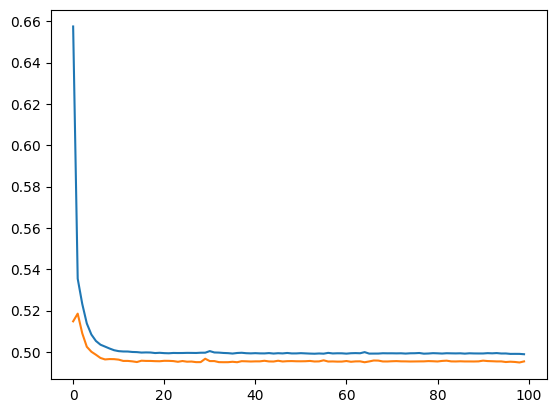

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

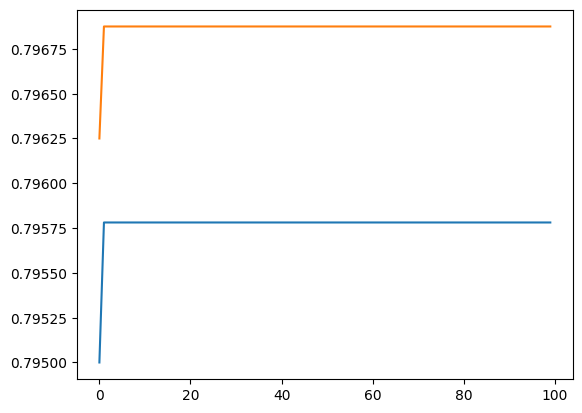

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])